#Import packages

In [1]:
import os

import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib.pyplot as plt

from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Lambda, Layer, Activation
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import metrics, optimizers, regularizers

from keras.utils.vis_utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

# Mount Google Drive and define path to data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# change the path to your drive or skip first line if running locally
%cd '/content/drive/MyDrive/ZEIS/Task2/Code'

path_to_na_handled_data = './data/no_missing_values/Bias_correction_ucl_without_na.csv'

# For saving later
path_to_training_x = './data/preprocessed/training/training_x.csv'
path_to_training_y = './data/preprocessed/training/training_y.csv'
path_to_test_x = './data/preprocessed/test/test_x.csv'
path_to_test_y = './data/preprocessed/test/test_y.csv'

/content/drive/MyDrive/ZEIS/Task2/Code


# Read data set

In [4]:
# Load the csv file
df = pd.read_csv(path_to_na_handled_data)

# Show data size
print(df.shape)

# Show first 5 rows
df.head()

(7725, 26)


,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Next_Tmax,Next_Tmin,Day,Month
0,1.0,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,...,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,29.1,21.2,30.0,6.0
1,2.0,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,...,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.5,22.5,30.0,6.0
2,3.0,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,...,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,31.1,23.9,30.0,6.0
3,4.0,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,...,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,31.7,24.3,30.0,6.0
4,5.0,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,...,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,31.2,22.5,30.0,6.0


# Data set split


*   Create a holdout set for final evaluation (10% of total data)
*   Reserve 600 of the remaining data for validation during training


In [5]:
target_features = ['Next_Tmax', 'Next_Tmin']
other_features =['station', 'Present_Tmax', 'Present_Tmin', 'LDAPS_RHmin', 'LDAPS_RHmax',
       'LDAPS_Tmax_lapse', 'LDAPS_Tmin_lapse', 'LDAPS_WS', 'LDAPS_LH',
       'LDAPS_CC1', 'LDAPS_CC2', 'LDAPS_CC3', 'LDAPS_CC4', 'LDAPS_PPT1',
       'LDAPS_PPT2', 'LDAPS_PPT3', 'LDAPS_PPT4', 'lat', 'lon', 'DEM', 'Slope',
       'Solar radiation', 'Day', 'Month']

# copy preprocessed data dropping target_features for x
x = df.drop(target_features, axis = 1)
# copy preprocessed data dropping other features for y
y = df.drop(other_features, axis = 1)

Perform random training (80%) and test (20%) set  split on the remaining 90% of the data after splitting the holdout set.
* y = ['Next_Tmax', 'Next_Tmin']
* x = the rest of the features

In [6]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1, random_state = 311)

# Reserve 600 samples for validation of the neural network
x_val = x_train[-600:]
y_val = y_train[-600:]
x_train = x_train[:-600]
y_train = y_train[:-600]

print('Training x and y shapes: ',x_train.shape,y_train.shape)
print('Validation x and y shapes:',x_val.shape,y_val.shape)
print('Holdout Test x and y shapes:',x_test.shape,y_test.shape)

Training x and y shapes:  (6352, 24) (6352, 2)
Validation x and y shapes: (600, 24) (600, 2)
Holdout Test x and y shapes: (773, 24) (773, 2)


Visualizing test and training set target feature distributions shows that they are similarly distributed.

[Text(0.5, 1.0, 'Next_Tmin y_test')]

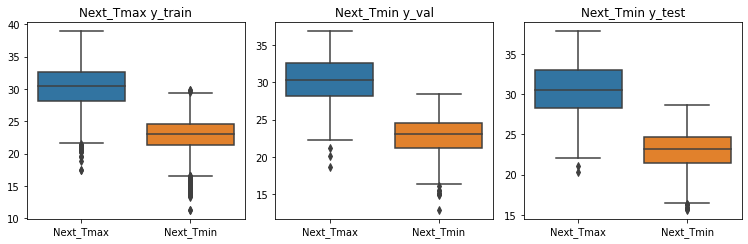

In [7]:
plt.rcParams["figure.figsize"] = [10.5, 3.5]
plt.rcParams["figure.autolayout"] = True
f, axes = plt.subplots(1, 3)

sns.boxplot(data=y_train,ax=axes[0]).set(title='Next_Tmax y_train')
sns.boxplot(data=y_val,ax=axes[1]).set(title='Next_Tmin y_val')
sns.boxplot(data=y_test,ax=axes[2]).set(title='Next_Tmin y_test')

In [8]:
# Show training x data size
print(x_train.shape)

# Show first 5 rows
x.head()

(6352, 24)


,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Day,Month
0,1.0,28.7,21.4,58.255688,91.116364,28.074101,23.006936,6.818887,69.451805,0.233947,...,0.0,0.0,0.0,37.6046,126.991,212.3350,2.7850,5992.895996,30.0,6.0
1,2.0,31.9,21.6,52.263397,90.604721,29.850689,24.035009,5.691890,51.937448,0.225508,...,0.0,0.0,0.0,37.6046,127.032,44.7624,0.5141,5869.312500,30.0,6.0
2,3.0,31.6,23.3,48.690479,83.973587,30.091292,24.565633,6.138224,20.573050,0.209344,...,0.0,0.0,0.0,37.5776,127.058,33.3068,0.2661,5863.555664,30.0,6.0
3,4.0,32.0,23.4,58.239788,96.483688,29.704629,23.326177,5.650050,65.727144,0.216372,...,0.0,0.0,0.0,37.6450,127.022,45.7160,2.5348,5856.964844,30.0,6.0
4,5.0,31.4,21.9,56.174095,90.155128,29.113934,23.486480,5.735004,107.965535,0.151407,...,0.0,0.0,0.0,37.5507,127.135,35.0380,0.5055,5859.552246,30.0,6.0


In [9]:
# Show validation x data size
print(x_val.shape)

# Show first 5 rows
x_val.head()

(600, 24)


,station,Present_Tmax,Present_Tmin,LDAPS_RHmin,LDAPS_RHmax,LDAPS_Tmax_lapse,LDAPS_Tmin_lapse,LDAPS_WS,LDAPS_LH,LDAPS_CC1,...,LDAPS_PPT2,LDAPS_PPT3,LDAPS_PPT4,lat,lon,DEM,Slope,Solar radiation,Day,Month
4465,3.0,29.7,23.0,57.558586,84.177925,25.416304,20.655409,12.804227,13.722363,0.513819,...,0.037895,0.387519,1.183392,37.5776,127.058,33.3068,0.2661,4689.235352,24.0,8.0
4218,3.0,31.7,22.4,40.847256,84.591034,32.987821,24.462867,5.337773,15.307918,0.075225,...,0.000000,0.000000,0.000000,37.5776,127.058,33.3068,0.2661,5034.395996,14.0,8.0
5868,8.0,33.8,27.3,55.042477,75.424553,31.338190,27.527771,5.549320,54.279283,0.205399,...,0.000000,0.000000,0.000000,37.4697,126.910,52.5180,1.5629,4852.797852,18.0,8.0
1567,21.0,29.4,21.9,36.755325,74.539299,32.663421,23.346720,6.225886,13.700477,0.037847,...,0.000000,0.000000,0.000000,37.5507,127.040,26.2980,0.5721,5859.321777,30.0,6.0
5704,19.0,35.4,24.8,44.161098,82.272118,34.530309,28.021702,6.177777,50.785527,0.221311,...,0.000000,0.000000,0.000000,37.5776,126.938,75.0924,1.7678,5131.667480,11.0,8.0


In [46]:
# Show validation x data size
print(y_val.shape)
pd.DataFrame(y_val).head()

(600, 2)


,0,1
0,25.0,19.6
1,32.0,23.0
2,33.4,27.8
3,31.5,21.9
4,35.4,24.9


Save splitted data sets.

In [10]:
# x_train.to_csv('./data/preprocessed/training/training_x.csv', index=False)
# y_train.to_csv('./data/preprocessed/training/training_y.csv', index=False)
# x_val.to_csv('./data/preprocessed/val/val_x.csv', index=False)
# y_val.to_csv('./data/preprocessed/val/val_y.csv', index=False)

In [11]:
# Convert pandas.df to numpy
x_train = x_train.values
y_train = y_train.values
x_val = x_val.values
y_val = y_val.values
x_test = x_test.values
y_test = y_test.values

# Building a RandomForestRegressor


we initiliaze a multi-output meta estimator from random forests and show that it has the same score of 0.91 with random forest.

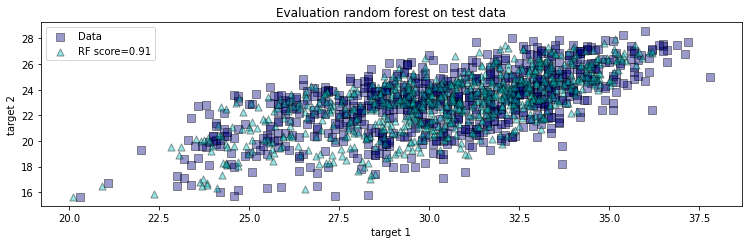

In [12]:
max_depth = 30

regr_rf = RandomForestRegressor(n_estimators=100, max_depth=max_depth, random_state=2)
regr_rf.fit(x_train, y_train)

# Predict on new data
y_rf = regr_rf.predict(x_test)

# Plot the results
plt.figure()
s = 50
a = 0.4
plt.scatter(
    y_test[:, 0],
    y_test[:, 1],
    edgecolor="k",
    c="navy",
    s=s,
    marker="s",
    alpha=a,
    label="Data",
)
plt.scatter(
    y_rf[:, 0],
    y_rf[:, 1],
    edgecolor="k",
    c="c",
    s=s,
    marker="^",
    alpha=a,
    label="RF score=%.2f" % regr_rf.score(x_test, y_test),
)
plt.xlabel("target 1")
plt.ylabel("target 2")
plt.title("Evaluation random forest on test data")
plt.legend()
plt.show()


# Building a Multioutput Regression SVM model

Building a Multioutput Regression SVM with Scikit-learn:
https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-perform-multioutput-regression-with-svms-in-python.md

We set the value for [latex]\epsilon[/latex] (epsilon) to 0.2. It specifies the width of the 'error tube' where no penalty is assigned to mispredictions, effectively allowing us to take values close to the edges of the error tube as support vectors.

If we want to apply regularization, we can also apply values for C - more information here.

Then, we can then easily wrap the SVR into our imported MultiOutputRegressor.

In [15]:
## Create two single output regressors for each of the targets
# Create the SVR regressor
svr = SVR(epsilon=0.1)

# Create the Multioutput Regressor
mor = MultiOutputRegressor(svr)

# Train the regressor
mor = mor.fit(x_train, y_train)

# Generate predictions for testing data
y_pred = mor.predict(x_test)

# Evaluate the regressor
mse_one = mean_squared_error(y_test[:,0], y_pred[:,0])
mse_two = mean_squared_error(y_test[:,1], y_pred[:,1])
print(f'MSE for first regressor: {mse_one} - second regressor: {mse_two}')
mae_one = mean_absolute_error(y_test[:,0], y_pred[:,0])
mae_two = mean_absolute_error(y_test[:,1], y_pred[:,1])
print(f'MAE for first regressor: {mae_one} - second regressor: {mae_two}')

MSE for first regressor: 9.3715681342754 - second regressor: 5.132726503959115
MAE for first regressor: 2.51758564157069 - second regressor: 1.790956708615669


# Building and training NWP NN

Define the model. Cho et al uses hidden dimension sizes of 22 and 19, which overfitted the model, therefore I experimented with hidden layer dimensions and found out these work out best.

In [128]:
# model architecture parameters
input_shape = x_train[0].shape
hidden_dim1_size = 12
hidden_dim2_size = 8
output_size= 2

# training parameters
learning_rate = 0.001
batch_size=200
max_epochs = 300


In [129]:
#set seed for reproducibility of weight inits
tf.random.set_seed(123)
init = tf.keras.initializers.GlorotNormal(seed=42)

# Define layers
inputs = Input(input_shape, name="features")
x = Dense(hidden_dim1_size, activation="relu", name="dense_1", kernel_initializer=init)(inputs)
x = Dense(hidden_dim2_size, activation="relu", name="dense_2", kernel_initializer=init)(x)
outputs = Dense(2, activation="relu", name="predictions", kernel_initializer=init)(x)

# Initialize and compile model
nwp = Model(inputs=inputs, outputs=outputs)
nwp.compile(optimizer="Adam", loss="mse", metrics=["mae", "cosine_proximity"])

# Training

Early stopping is introduced with patience of 3 epochs to prevent overfitting. Experimenting with epoch counts of 100 and 200 resulted in underfitting. With max epoch count of 300, model stopped at the epoch 298. 

Trained model shows high correlation with validation data: cosine_proximity of 0.99.

In [130]:
# Early stopping callback:
# This callback will stop the training when there is no improvement in
# the loss for three consecutive epochs.
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

print("Fit model on training data")
history = nwp.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=max_epochs,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),
    callbacks=[callback],
)

Fit model on training data
Epoch 1/300
32/32 [==============================] - 1s 8ms/step - loss: 370271.2188 - mae: 580.6644 - cosine_proximity: 0.9658 - val_loss: 116031.3047 - val_mae: 338.1759 - val_cosine_proximity: 0.9835
Epoch 2/300
32/32 [==============================] - 0s 3ms/step - loss: 49478.0703 - mae: 206.4648 - cosine_proximity: 0.9499 - val_loss: 12914.6787 - val_mae: 100.4777 - val_cosine_proximity: 0.8840
Epoch 3/300
32/32 [==============================] - 0s 3ms/step - loss: 5982.6528 - mae: 60.3663 - cosine_proximity: 0.8343 - val_loss: 1754.6754 - val_mae: 32.2183 - val_cosine_proximity: 0.7997
Epoch 4/300
32/32 [==============================] - 0s 3ms/step - loss: 929.3033 - mae: 23.9899 - cosine_proximity: 0.8194 - val_loss: 388.5081 - val_mae: 16.2792 - val_cosine_proximity: 0.8621
Epoch 5/300
32/32 [==============================] - 0s 3ms/step - loss: 250.5334 - mae: 12.8036 - cosine_proximity: 0.9155 - val_loss: 176.1534 - val_mae: 10.9417 - val_cosine_

In [131]:
history.history

Plot loss graph: Early stopping helped to prevent overfitting and stopped the training et epoch 298. Drastical changes are observed especially in the beginning, then continued till 150th epoch. 

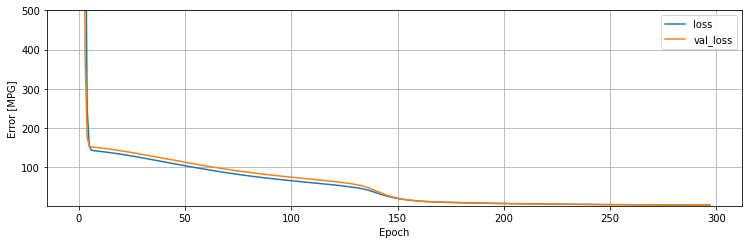

In [140]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([1, 500])
  plt.xlabel('Epoch')
  plt.ylabel('Error [MPG]')
  plt.legend()
  plt.grid(True)
plot_loss(history)

In [133]:
# save the model
# Model(nwp).save_weights('./models/saved/cho_nwp.h5')

# Holdout Test

model outputs show a very  high correlation of 0.993 with the holdout data.

In [132]:
nwp.evaluate(x_test, y_test, batch_size=batch_size) 

4/4 [==============================] - 0s 5ms/step - loss: 3.0578 - mae: 1.3896 - cosine_proximity: 0.9993


[3.0577569007873535, 1.3896420001983643, 0.9993394017219543]

Calculate RMSE on the holdout set

In [166]:
y_predicted = nwp.predict(x_test)
rmse = mean_squared_error(y_test, y_predicted, squared=False)
print(rmse)

1.7426952253750145


# Build Multi-Model-Ensemble

In the paper they use average of all models. Currently ensemble.VotingRegressor does not support multioutput: https://scikit-learn.org/stable/modules/ensemble.html#voting-regressor.  So we will just take the average of predictions for final evaluation of the MME model.

In [174]:
# Calculate the average of rf, svm and nwp nn predictions
ensemble_preds = (y_rf + y_pred + y_predicted) / 3.0

print(f"Final Ensemble RMSE on Test Set: {np.sqrt(mean_squared_error(ensemble_preds, y_test)):.5f}")

Final Ensemble RMSE on Test Set: 1.54028
